In [2]:
#####
#preliminary functions
#####

using Printf
using Plots
using LinearAlgebra
using Statistics

######
#WA mc routine

const L       = 10             # linear size of lattice
const temps   = 1.2:-0.2:0.1  # temperatures to sample
const nt = length(temps)      #number of temperatures
#the 4 different bond directions on the lattice
#index 1,2 is the direction in x,y 
#index 3 is the default link value in that direction
#link_default = [1,1,-1,-1]



#these arrays allow us to selct the x or y direction bonds
all_x = ones(Int32, 2*L, 2*L)
all_y = ones(Int32, 2*L, 2*L)

for i in 1:2:2*L
    all_x[:,i] = zeros(Int32, 2*L)
    all_y[i,:] = zeros(Int32, 2*L)
end

In [80]:
#######
#second attempts after Kun's insight
#######

dir_list = [[[1,0],1], [[0,1],1], [[-1,0],-1], [[0,-1,],-1]] 
#index 1,2 is the direction in x,y 
#index 3 is the default link value in that direction
#link_default = [1,1,-1,-1]



#these arrays allow us to selct the x or y direction bonds
all_x = ones(Int32, 2*L, 2*L)
all_y = ones(Int32, 2*L, 2*L)

for i in 1:2:2*L
    all_x[:,i] = zeros(Int32, 2*L)
    all_y[i,:] = zeros(Int32, 2*L)
end

function mod_latt_plus(site, direction_shift)
    val = ones(Int32, 2) + mod.(site - ones(Int32, 2) + direction_shift, 2*L)
    return val
end



function sweep_v2(nv, ratio, all_map, kappa) 
    
    ci = 0
    
    w_list = []
    accum_w_list = []
    accum_winding = 0
    
    g_map = zeros(Int32, L, L)
    
    i = 0
        
    #set a starting worm.
    Is = [2*rand(1:L), 2*rand(1:L)] #this arbitrary choice does not matter
    Ms = Is
    
    dist_M_to_I = [0,0]
    cond_IequMpm1 = false
    cond_IequM = true
    gs_map = [1,1]
    has_worm = false
    Z_count = 0
    #these conditions set parameters such that the first thing done is to start a worm
    
    while i <= nv
        
        q_c = rand()
        p = rand()
            
        if (q_c < 1/3)
            #create a worm, in Z sector
            #display("created worm")
            if !has_worm
                Is = [2*rand(1:L), 2*rand(1:L)]
                Ms = Is
                #dist_M_to_I = [0,0]
                gs_map = [1,1]
                

                dir_link, prop_add = dir_list[rand(1:4)] #random link direction and change in bond value
                
                link_v = mod_latt_plus(Ms, dir_link)
                link_val = all_map[CartesianIndex(link_v[1], link_v[2])] #that's the current bond value
                new_val = link_val + prop_add #new bond value
                deltaS = (ratio)*(new_val^2 - link_val^2) 
                #random number and acceptance test
                barrier = minimum([1, kappa*exp(-deltaS)])
                if (p < barrier)
                    #if you accept the move
                    all_map[CartesianIndex(link_v[1], link_v[2])] = new_val
                    Ms = mod_latt_plus(Ms, 2*dir_link)
                    dist_M_to_I += dir_link
                    
                    has_worm = true
                    Z_count += 1
                    
                    gs_map = ones(Int32, 2) + mod.(dist_M_to_I, L)
                    g_map[CartesianIndex(gs_map[1], gs_map[2])] += 1
                end
            end
        elseif (1/3 <= q_c < 2/3)
            #display("annihilate worm")
            #annihilate a worm, in G sector - goes to Z sector
            if has_worm && cond_IequMpm1
                #find the link connecting I and M - these two are close to each other!
                index = 1
                for uv in 1:4
                    new_Ms = mod_latt_plus(Ms, 2*dir_list[uv][1])
                    if new_Ms == Is
                        index = uv
                    end
                end
                
                dir_link, prop_add = dir_list[index]

                link_v = mod_latt_plus(Ms, dir_link) #find the link index 
                link_val = all_map[CartesianIndex(link_v[1], link_v[2])] #that's the current bond value
                new_val = link_val + prop_add #new bond value
                deltaS = (ratio)*(new_val^2 - link_val^2) 
                #random number and acceptance test
                barrier = minimum([1, (1.0/(kappa))*exp(-deltaS)])
                if (p < barrier)
                    #if you accept the move
                    all_map[CartesianIndex(link_v[1], link_v[2])] = new_val
                    Ms = Is
                    dist_M_to_I += dir_link
                    has_worm = false
                    
                    #you are now in Z sector, only closed loops!
                    #dist_M_to_I = [0,0]
                    gs_map = [1,1]
                    g_map[1,1] += 1
                end
            end
        else
            #move a worm
            #display("move worm")
            if has_worm #you have an open worm! move it
                dir_link, prop_add = dir_list[rand(1:4)] #random link direction and change in bond value
                
                link_v = mod_latt_plus(Ms, dir_link)
                link_val = all_map[CartesianIndex(link_v[1], link_v[2])] #that's the current bond value
                new_val = link_val + prop_add #new bond value
                deltaS = (ratio)*(new_val^2 - link_val^2) 


                #set the barrier height
                barrier = minimum([1, exp(-deltaS)])

                if (p < barrier)
                    #if you accept the move
                    all_map[CartesianIndex(link_v[1], link_v[2])] = new_val
                    Ms = mod_latt_plus(Ms, 2*dir_link)
                    dist_M_to_I += dir_link

                    gs_map = ones(Int32, 2) + mod.(dist_M_to_I, L)
                    g_map[CartesianIndex(gs_map[1], gs_map[2])] += 1
                end
            end
        end
        
        #dist = ones(Int32, 2) + mod.(dist_M_to_I, L)
            
        #dist = (dist_M_to_I[1]%(L+1))^2 + (dist_M_to_I[2]%(L+1))^2
        #cond_IequMpm1 = (dist == 1 || dist == L) 
        #below, this tells me my open worm is 1 bond short of being closed
        cond_IequMpm1 = (gs_map == [1,2] || gs_map == [2,1] || gs_map == [1, L] || gs_map == [L,1])
        #cond_IequM = (Is == Ms) #this tells me if my worm is closed (true) or not
        
        #display(Is - Ms)
           
        #slow measurement, done when worm is closed
        if false
            if true
                if !has_worm 
                    winding = ((sum(all_map.*all_x)/L)^2 + (sum(all_map.*all_y)/L)^2)
                    ci +=1
                    push!(w_list, winding)
                    #energy = (g_map_temp[1,2] + g_map_temp[2,1]+ g_map_temp[1,L] + g_map_temp[L,1])/(2)
                    #magsq = sum(g_map_temp)
                end
            end
        end
        
        if !has_worm
            winding = (dist_M_to_I[1]/L)^2 + (dist_M_to_I[2]/L)^2
            push!(w_list, winding)
            
            accum_winding += winding
            push!(accum_w_list, accum_winding/length(accum_w_list))
        end
        #fast measurement
        
        i += 1
        
    end
    
    #display(ci)
    
    return w_list, accum_w_list, g_map, Z_count
end



sweep_v2 (generic function with 1 method)

In [97]:
####
T = 1.0
β = 1/T
ratio = 1/(β)
@printf "Temperature %.2f" T
@printf "\n"

all_map = zeros(Int32,2*L, 2*L) 

#first, thermalize
sweep_v2((10^4)*L^2, ratio, all_map, 4)
w_list, accum_w_list, g_map_vals, Z_count = sweep_v2((10^4)*L^2, ratio, all_map, 4)

w_length = length(accum_w_list)
#w_t = T*mean(accum_w_list[Int(w_length/3):end])
final_w = accum_w_list[floor(Int, 2*w_length/3):end]*T
w_t = final_w[end]
w_t_std = (maximum(final_w) - minimum(final_w))/2
@printf "Stiffness %.3f ± %.3f" w_t w_t_std
@printf "\n"
energy = -(g_map_vals[1,2] + g_map_vals[2,1] + g_map_vals[1,L] + g_map_vals[L,1])/Z_count
@printf "Energy %.2f" energy


Temperature 1.00
Stiffness 0.181 ± 0.007
Energy -2.11

In [56]:
Int(length(w_list)/3)

41764

In [43]:
T*mean(w_list[1:100000])

1.3798812

In [44]:
T*mean(w_list[300000:end])

1.5065083233150296

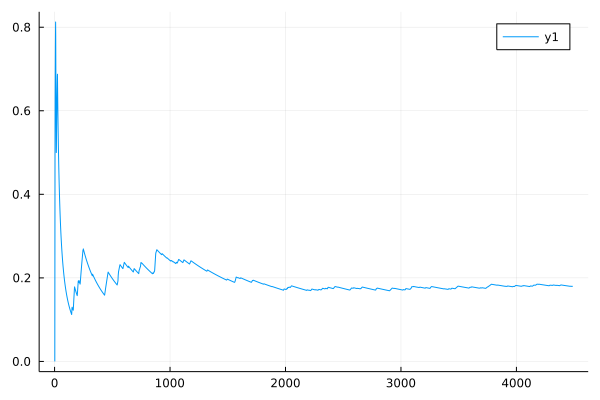

In [98]:
plot(T*accum_w_list[1:10:end])

In [25]:
w_list[1000:1060]

61-element Vector{Any}:
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 ⋮
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0

In [8]:
energy = -(g_map_vals[1,2] + g_map_vals[2,1] + g_map_vals[1,L] + g_map_vals[L,1])/g_map_vals[1,1]

1.74901625320787

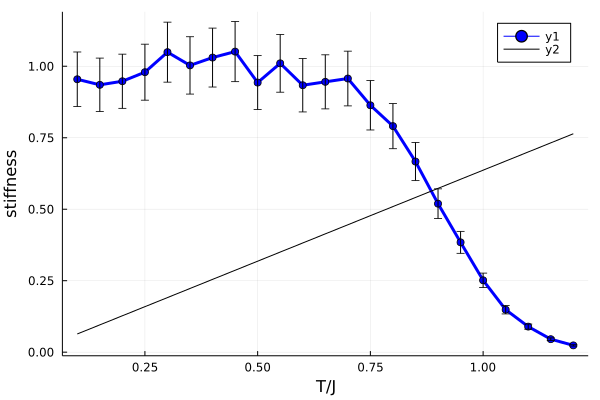

In [26]:
#ifyou run for different temperatures, then you can plot the stiffness vs T

if false
    plot(temps, rho, yerr = rho_err/L, lw = 3, shape = :circle, color = :blue, markersize = 4)
    plot!(temps, 2*temps/pi, lw = 1, color = :black)
    xlabel!("T/J")
    ylabel!("stiffness")
end

In [ ]:


function createW(p, factor, ratio, all_map, g_map)
    Ix = 2*rand(1:L)
    Iy = 2*rand(1:L)
    Mx = Ix
    My = Iy
    dist_M_to_I = [0,0]
    
    dir_link = dir_list[rand(1:4)] #random link direction
    link_x = 1 + mod(Mx - 1 + dir_link[1], 2*L) #find the link index - x
    link_y = 1 + mod(My - 1 + dir_link[2], 2*L) #find the link index - y
    link_val = all_map[link_x, link_y] #that's the current bond value
    prop_add = dir_link[3] #change of bond value
    new_val = link_val + prop_add #new bond value
    deltaS = (ratio)*(new_val^2 - link_val^2) 
    #random number and acceptance test
    barrier = minimum([1, factor*exp(-deltaS)])
    if (p < barrier)
        #if you accept the move
        all_map[link_x, link_y] = new_val
        Mx = 1 + mod(Mx - 1 + 2*dir_link[1], 2*L)
        My = 1 + mod(My - 1 + 2*dir_link[2], 2*L)
        dist_M_to_I += dir_link[1:2]
        
        g_x = 1 + mod(dist_M_to_I[1], L)
        g_y = 1 + mod(dist_M_to_I[2], L)
        g_map[g_x, g_y] += 1
    end
end

function annihilateW(p, factor, ratio, all_map, g_map)
    dir_link = dist_M_to_I
    link_x = 1 + mod(Mx - 1 + dir_link[1], 2*L) #find the link index - x
    link_y = 1 + mod(My - 1 + dir_link[2], 2*L) #find the link index - y
    link_val = all_map[link_x, link_y] #that's the current bond value
    prop_add = dir_link[3] #change of bond value
    new_val = link_val + prop_add #new bond value
    deltaS = (ratio)*(new_val^2 - link_val^2) 
    #random number and acceptance test
    barrier = minimum([1, factor*exp(-deltaS)])
    if (p < barrier)
        #if you accept the move
        all_map[link_x, link_y] = new_val
        Mx = Ix
        My = Iy
        #you are now in Z sector, only closed loops!
        dist_M_to_I = [0,0]
        g_map[1,1] +=1
    end
end

function moveW(p, ratio, all_map, g_map)
    dir_link = dir_list[rand(1:4)]
    link_x = 1 + mod(Mx - 1 + dir_link[1], 2*L) #find the link index - x
    link_y = 1 + mod(My - 1 + dir_link[2], 2*L) #find the link index - y
    link_val = all_map[link_x, link_y] #that's the current bond value
    prop_add = dir_link[3] #change of bond value
    new_val = link_val + prop_add #new bond value
    deltaS = (ratio)*(new_val^2 - link_val^2) 
    
    Mx_temp = 1 + mod(Mx - 1 + 2*dir_link[1], 2*L)
    My_temp = 1 + mod(My - 1 + 2*dir_link[2], 2*L)
    #random number and acceptance test
    if Mx_temp == Ix && My_temp == Iy
        #if you picked a spot that can annihilate, drop it. Use the annihilate function instead
        barrier = 0
    else
        #set the barrier height
        barrier = minimum([1, exp(-deltaS)])
    end 
    
    if (p < barrier)
        #if you accept the move
        all_map[link_x, link_y] = new_val
        all_map[link_x, link_y] = new_val
        Mx = Mx_temp
        My = My_temp
        #you are now in Z sector, only closed loops!
        dist_M_to_I += dir_link[1:2]
        
        g_x = 1 + mod(dist_M_to_I[1], L)
        g_y = 1 + mod(dist_M_to_I[2], L)
        g_map[g_x, g_y] += 1
    end
end
